# Policy Gradient Swing-Up Activity

The goal of this activity is to use reinforcement learning to train a policy that can swing-up and balance an inverted pendulum. This is a significantly more difficult challenge than the simpler balancing that we tested PID and LQR with.

In this notebook, you will be exposed to tools used to train reinforcement learning algorithms, including:
- [mujoco](https://github.com/google-deepmind/mujoco), a very popular open-source simulator in robotics due to its physical accuracy, computational efficiency, and differentiability,
- [jax](https://en.wikipedia.org/wiki/Google_JAX), a machine learning framework (numpy on steroids) built for speed,
- [ppo](https://paperswithcode.com/method/ppo) (proximal policy optimization), a policy gradient method in reinforcement learning.

Our previous simulation tools and mathematical libraries just don't cut it - they're not fast enough / don't support the mathematical operations needed to train an RL policy.

### Your task (Located in Section 5.1):
Your task will be to implement parts of the **reward function** to train the reinforcement learning policy. Like a cost function for LQR, the reward function is incredibly important to determine the performance of the system.

The code in the background to get this to work is more complicated than the previous assignments, so hang on for the ride!

### **Warning:**

Training the reinforcement learning policy takes ~10-15 minutes, even with the NVIDIA T4 Tensor Core GPU that our colab has access to. Keep this in mind when starting the training script or clicking "run all."

# Step 1: Installing requirements!

Install the required libraries and packages for the simulator and RL training pipeline.

In [ ]:
# --- INSTALLS ---
!pip install -q mujoco # Defining simulation environments and high fidelity physics
!pip install -q mujoco_mjx # Accelerating simulation with GPUs
!pip install -q brax # Training RL agents
!pip install -q ipdb # Debugging

In [ ]:
# --- CHECK AND CONFIGURE INSTALLATIONS ---
from google.colab import files

import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Tell XLA to use Triton GEMM, this improves steps/sec by ~30% on some GPUs
xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags

Setting environment variable to use GPU rendering:
env: MUJOCO_GL=egl
Checking that the installation succeeded:
Installation successful.


In [ ]:
# --- IMPORT PLOTTING AND GRAPHICS PACKAGES ---
import time
import itertools
import numpy as np
from typing import Callable, NamedTuple, Optional, Union, List

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

Installing mediapy:


In [ ]:
# --- IMPORT MUJOCO, MJX AND BRAX ---
from datetime import datetime
from etils import epath
import functools
from IPython.display import HTML
from typing import Any, Dict, Sequence, Tuple, Union
import os
from ml_collections import config_dict


import jax
from jax import numpy as jp
import numpy as np
from flax.training import orbax_utils
from flax import struct
from matplotlib import pyplot as plt
import mediapy as media
from orbax import checkpoint as ocp

import mujoco
from mujoco import mjx

from brax import base
from brax import envs
from brax import math
from brax.base import Base, Motion, Transform
from brax.envs.base import Env, PipelineEnv, State
from brax.mjx.base import State as MjxState
from brax.training.agents.sac import train as sac
from brax.training.agents.ppo import train as ppo
from brax.training.agents.ppo import networks as ppo_networks
from brax.io import html, mjcf, model

In [ ]:
# --- SHOW DEPENDENCY VERSIONS ---
from importlib.metadata import version

# The core critical libraries for your project
key_packages = [
    "mujoco",
    "mujoco-mjx",
    "brax",
    "jax",
    "jaxlib",
    "mediapy",
    "matplotlib",
    "flax",
    "orbax-checkpoint"
]

print("# --- FUTURE PROOF INSTALL BLOCK ---")
print("")
for pkg in key_packages:
    try:
        v = version(pkg)
        # We print it in the format needed for a pip install cell
        print(f"!pip install -q {pkg}=={v}")
    except Exception as e:
        print(f"# Could not find version for {pkg}")

# --- FUTURE PROOF INSTALL BLOCK ---

!pip install -q mujoco==3.4.0
!pip install -q mujoco-mjx==3.4.0
!pip install -q brax==0.14.0
!pip install -q jax==0.7.2
!pip install -q jaxlib==0.7.2
!pip install -q mediapy==1.2.5
!pip install -q matplotlib==3.10.0
!pip install -q flax==0.10.7
!pip install -q orbax-checkpoint==0.11.31


# Step 2. Define the cart-pole model!

This is a crucial step, where we define the physical properties of the cartpole model for the mujoco simulation.

In contrast to the simulator used prior, we are able to model static friction for the cart and the pole. This introduces a "sim to sim" gap between our two simulators.

In addition, we define the geometry of the cartpole system in an XML format. This defines the geometries, the frames, and the positions of our system for simulation.

In [ ]:
# --- DEFINE SIMULATION ENVIRONMENT AS MUJOCO XML ---
cart_mass = 0.261 # [kg]
pole_mass = 0.351 # [kg]
pole_inertia = 0.0105 # [kgm^2 about CoM]

cart_damping = 0.2 # [N/(m/s)]
cart_static_friction = 0.4 # [N]

pole_damping = 0.00075 # [Nm/(rad/s)]
pole_static_friction = 0.0051 # [Nm]

X_LIM = 0.8 # [m] Range that cart is allowed to move
A_LIM = 20 # [N] - Force limit

inverted_pendulum_xml = f"""
<mujoco model="inverted pendulum">
  <compiler inertiafromgeom="false"/>
  <default>
    <geom contype="0" friction="1 0.1 0.1" rgba="0.4 0.33 0.26 1.0"/>
  </default>
  <asset>
    <texture type="skybox" builtin="gradient" rgb1="1 1 1" rgb2=".6 .8 1" width="512" height="512"/>
  </asset>
  <option gravity="0 0 -9.81" timestep="0.004" />
  <asset>
      <texture name="grid" type="2d" builtin="checker" width="512" height="512" rgb1=".2 .4 .6"
          rgb2=".4 .6 .8" />
      <material name="grid" texture="grid" texrepeat="1 1" texuniform="true" reflectance="0" />
  </asset>
  <visual> <global glow="0.0"/> <headlight active="1" diffuse="4.0 4.0 4.0"/> </visual>
  <worldbody>
    <geom name="rail" pos="0 0 0" quat="0.707 0 0.707 0" size="0.01 1.0" type="capsule" rgba="0 0 0 1"/>
    <geom name="floor" pos="0 0 -1" size="0 0 .05" type="plane" material="grid" condim="3" contype="0" conaffinity="0" />
    <body name="cart" pos="0 0 0">
      <joint axis="1 0 0" limited="true" name="slider" pos="0 0 0" range="-0.5 0.5" type="slide" damping="{cart_damping}" frictionloss="{cart_static_friction}"/>
      <geom name="cart" pos="0 0 0" quat="0.707 0 0.707 0" size="0.05 0.05" type="capsule" rgba="0.25 0.25 0.25 1"/>
      <inertial mass="{cart_mass}" pos="0 0 0" diaginertia="1 1 1"/>
      <body name="pole" pos="0 0 0">
        <inertial mass="{pole_mass}" pos="0 0 -0.3" diaginertia="1.0 {pole_inertia} 1.0"/>
        <joint axis="0 1 0" name="hinge" pos="0 0 0" limited="false" type="hinge" damping="{pole_damping}" frictionloss="{pole_static_friction}" />
        <geom fromto="0 0 0 0 0 -0.6" name="cpole" size="0.014 0.014" type="capsule" rgba="0.5 0 0 1"/>
      </body>
    </body>
    <camera name="tracking_cam" mode="targetbody" target="cart" pos="1.0 -1.0 1.0" />
  </worldbody>
  <actuator>
    <motor ctrllimited="true" ctrlrange="-{A_LIM} {A_LIM}" gear="1" joint="slider" name="slide"/>
  </actuator>
</mujoco>
"""

# Make model, data, and renderer
mj_model = mujoco.MjModel.from_xml_string(inverted_pendulum_xml)
mj_data = mujoco.MjData(mj_model)
renderer = mujoco.Renderer(mj_model, width=480, height=480)

# Put model and data on GPU with MJX
mjx_model = mjx.put_model(mj_model)
mjx_data = mjx.put_data(mj_model, mj_data)

Let's print the model options to see the characteristics of our mujoco model. There are a number of factors that we can check:

`gravity`: A 3D vector [x, y, z] representing the gravity acceleration. \\
`timestep`: The duration of each simulation step. \\
`integrator`: Specifies the numerical integrator:
 - 0: Euler
 - 1: RK4 (Runge-Kutta 4)
 - 2: Implicit \\

`solver`: The solver used for physics simulation. \\
`tolerance`: Convergence tolerance for constraints. \\
`iterations`: Maximum number of solver iterations. \\

In [ ]:
# Print model options!
mj_model.opt

<MjOption
  ccd_iterations: 35
  ccd_tolerance: 1e-06
  cone: 0
  density: 0.0
  disableactuator: 0
  disableflags: 0
  enableflags: 0
  gravity: array([ 0.  ,  0.  , -9.81])
  impratio: 1.0
  integrator: 0
  iterations: 100
  jacobian: 2
  ls_iterations: 50
  ls_tolerance: 0.01
  magnetic: array([ 0. , -0.5,  0. ])
  noslip_iterations: 0
  noslip_tolerance: 1e-06
  o_friction: array([1.   , 1.   , 0.005, 0.   , 0.   ])
  o_margin: 0.0
  o_solimp: array([0.9  , 0.95 , 0.001, 0.5  , 2.   ])
  o_solref: array([0.02, 1.  ])
  sdf_initpoints: 40
  sdf_iterations: 10
  sleep_tolerance: 0.0001
  solver: 2
  timestep: 0.004
  tolerance: 1e-08
  viscosity: 0.0
  wind: array([0., 0., 0.])
>

## Step 3. Visualize the model

We can use mujoco's visualization engine to render our model, and double-check the dynamics (without any control).

In [ ]:
# --- SIMULATE XML ENVIRONMENT ON GPU ---
# Enable/disable joint visualization option:
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = False

duration = 5  # (seconds)
framerate = 60  # (Hz)

jit_step = jax.jit(mjx.step)

frames = []
mujoco.mj_resetData(mj_model, mj_data)
mjx_data = mjx.put_data(mj_model, mj_data)
while mjx_data.time < duration:
  mjx_data = jit_step(mjx_model, mjx_data)
  if len(frames) < mjx_data.time * framerate:
    mjx_data = mjx_data.replace(ctrl=2)
    mj_data = mjx.get_data(mj_model, mjx_data)
    renderer.update_scene(mj_data, scene_option=scene_option)
    pixels = renderer.render()
    frames.append(pixels)

# Show video
media.show_video(frames, fps=framerate)

## Step 4. Benchmarking the model

An important step is to "benchmark" or measure the performance of our model.

The function `benchmark(mj_model, batch_size=2048)` is used to measure the performance of MuJoCo's Just-In-Time (JIT) compilation and physics simulation speed.

"Steps per sec" gives us a measure of how fast MuJoCo is simulating the physics model.

In [ ]:
from mujoco.mjx import benchmark
jit_time, run_time, steps = benchmark(mj_model, batch_size=2048)
physics_steps_per_sec = steps / run_time
print('Steps per sec: ', physics_steps_per_sec)

# Step 5. Define the cartpole learning environment!

Now that we have the simulation and model parameters sorted out, we need to define the learning environment for our cartpole.

The main tasks here are to define our reward functions (your task), as well as the training environments or domain (what kind of environments are we going to expose the policy to)?

# 5.1: Implement the angular reward function!

Your task is to help implement the reward function, which is crucial to the reinforcement learning process.

There are several requirements/guidelines for a good reward function:
- **Informative & Goal-Driven**: The function should provide a meaningful signal that encourages the agent to reach target_angle, with a maximum reward exactly at the target angle.

- **Smooth & Differentiable**: The function should be continuous and differentiable, avoiding sudden jumps that can destabilize learning.

- **Bounded & Normalized**: The function is in the range [0,1][0,1], preventing excessively large gradients.

- **Handles Angular Periodicity**: The reward function should avoid discontinuities, even as the pole swings around 360 degrees multiple times.

We propose the following reward function:
$$
R(\theta) = \exp \left( - \left( \tan^{-1} \left( \frac{\sin(\theta - \theta_{\text{target}})}{\cos(\theta - \theta_{\text{target}})} \right) \right)^2 \right)
$$

This reward function is broken into two parts:

**Part 1: Angle error.**

$$
\theta_{error} = \tan^{-1} \left( \frac{\sin(\theta - \theta_{\text{target}})}{\cos(\theta - \theta_{\text{target}})} \right)
$$


This function computes the shortest angular difference between `theta` and `target_angle` while handling wrap-around effects of angles in a continuous manner. It also ensures that $\theta_{error}$ values remain within $[−\pi,\pi]$ and avoids discontinuities.

**Part 2: Exponential Reward Decay.**

$$
R(\theta) = \exp(-\theta_{error}^2)
$$

The exponential reward decay is key, because it maps the angle error to a more  Gaussian-like shape, with the following properties:
- The maximum reward $(1.0)$ occurs when $\theta=\theta_{target}$​.
- The reward decays smoothly as $\theta$ deviates from $\theta_{target}$​.
- The exponential function ensures non-negative values.

**NOTE:** Due to the complexity and criticality of the theta reward $R(\theta)$, we have implemented it for you as `theta_dot_reward`.

**Your task:**
Implement the remaining reward functions described in the functions below:
- `theta_dot_reward` (angular velocity)
- `x_reward` (position)
- `x_dot_reward` (linear velocity)

In [ ]:
def reward_theta_fn(theta, target_angle=jp.pi):
  """Theta reward function for the cart pole task.
  You are encouraged to use the following jax functions:
  jp.exp(), jp.atan2(), jp.cos(), jp.sin(), jp.pi

  Note that jp.atan2(y, x) accepts arguments in the form of y,x
  """
  theta_reward = jp.exp(-(jp.atan2(jp.sin(theta - target_angle), jp.cos(theta - target_angle)))**2)
  return theta_reward

# --- YOUR CODE HERE ---

def reward_theta_dot_fn(theta_dot):
  theta_dot_reward = NotImplemented
  return theta_dot_reward

def reward_x_fn(x):
  x_reward = NotImplemented
  return x_reward

def reward_x_dot_fn(x_dot):
  x_dot_reward = NotImplemented
  return x_dot_reward

# --- END ---


<details>
  <summary><strong>Show/Hide Solution</strong></summary>

One possible implementation of the rewards could be the following:

```
  theta_dot_reward = - jp.abs(theta_dot) * 0.001
  x_reward = - x**2 * 0.01
  x_dot_reward = - jp.abs(x_dot) * 0.001
```

Note that the function we actually used for the x-reward was a bit more complicated. We wanted to significantly penalize positions near the extremes of the cart rail. You can try this out and plot this for visualization.
```
def reward_x_fn(x, dip_points=[0.4], depth=-5, width=0.01):
    dip_sum = jp.zeros_like(x)

    for dp in dip_points:
        dip_sum += jp.exp(-((x - dp) ** 2) / (2 * width ** 2))  # Positive dip
        dip_sum += jp.exp(-((x + dp) ** 2) / (2 * width ** 2))  # Mirrored negative dip
    return depth * dip_sum
```


</details>


### Sanity Check: Plotting our Reward Function

Let's consider a set of possible angle values $\theta \in [-4\pi, 4\pi]$. What does our reward look like?

In [ ]:
# prompt: plot jp.exp(- (theta - jp.pi)**2)

import matplotlib.pyplot as plt
import jax.numpy as jp
import numpy as np

theta = np.linspace(-4*np.pi, 4*np.pi, 1000)
plt.plot(theta, reward_theta_fn(theta))
plt.xlabel("theta (rad)")
plt.ylabel("reward")
plt.title("Plot of theta reward")
plt.show()

theta_dot = np.linspace(-np.pi, np.pi, 1000)
plt.plot(theta, reward_theta_dot_fn(theta_dot))
plt.xlabel("theta dot (rad/s)")
plt.ylabel("reward")
plt.title("Plot of theta dot reward")
plt.show()

x = np.linspace(-1, 1, 1000)
plt.plot(theta, reward_x_fn(x))
plt.xlabel("x (m)")
plt.ylabel("reward")
plt.title("Plot of x reward")
plt.show()

x_dot = np.linspace(np.pi, np.pi, 1000)
plt.plot(theta, reward_x_dot_fn(theta))
plt.xlabel("x_dot (m/s)")
plt.ylabel("reward")
plt.title("Plot of x dot reward")
plt.show()

Notice how the reward is _maximized_ when $\theta$ is a multiple of $\pi$. (This is because, in contrast to our cart pole sim and hardware, we define the "swing-up" position in mujoco to be $\theta = \pi$. When we deploy the learned model on the hardware, we have to remember to shift $\theta$ by $180^\circ$!)

Notice also how this reward function is much _sharper_ than a vanilla sinusoid function. This will encourage the policy to really emphasize getting the pole position to $\theta = \pi$ (swing up).

# Step 6. Create the Cartpole Environment!

Here, we specifty things like the action space (`action_min` and `action_max`), hyperparameters (like solver, iteration, and other step parameters), and some helper functions like `step`, `reset`, and `_get_obs`. These functions are the typical architecture of any RL training pipeline.

The `step` function runs one timestep of the environment's dynamics. Notice that it takes in the current state and current action, and outputs the next state.


In [ ]:
# --- CREATE INVERTED PENDULUM ENVIRONMENT ---
class InvertedPendulum(PipelineEnv):
  def __init__(
      self,
      xml_string,
      **kwargs,
  ):
    mj_model = mujoco.MjModel.from_xml_string(xml_string)
    mj_model.opt.solver = mujoco.mjtSolver.mjSOL_NEWTON
    mj_model.opt.iterations = 2
    mj_model.opt.ls_iterations = 6

    sys = mjcf.load_model(mj_model)

    self.action_min = sys.actuator.ctrl_range[:, 0]
    self.action_max = sys.actuator.ctrl_range[:, 1]

    # Default to 5 physics steps per control step
    # With dt=0.004, this equates to 50hz control rate
    physics_steps_per_control_step = 5
    kwargs['n_frames'] = kwargs.get(
        'n_frames', physics_steps_per_control_step)
    kwargs['backend'] = 'mjx'

    super().__init__(sys, **kwargs)


  # Define the reset method to initialize the environment state
  def reset(self, rng: jp.ndarray) -> State:
    """Resets the environment to an initial state."""
    rng, rng1, rng2, rng3, rng4 = jax.random.split(rng, 5)

    # Initialize the pendulum and cart at various positions / velocities
    # We found that it doesn't train the swingup unless you initialize
    # the system at random states. This makes the exploration easier!
    qpos = jp.array([jax.random.uniform(rng, minval=-0.25, maxval=0.25),
                     jax.random.uniform(rng1, minval=-jp.pi, maxval=jp.pi)])
    qvel = jp.array([jax.random.uniform(rng2, minval=-1.0, maxval=1.0),
                     jax.random.uniform(rng3, minval=-jp.pi, maxval=jp.pi)])

    # Initialize the pipeline with the positions and velocities
    data = self.pipeline_init(qpos, qvel)

    # Get the initial observations
    obs = self._get_obs(data, jp.zeros(self.sys.nu))
    reward, done, zero = jp.zeros(3)

    # Initialize metrics
    metrics = {
        'reward_theta': zero,
        'reward_theta_dot': zero,
        'reward_x_dot': zero,
        'reward_x': zero,
        'total_reward': zero
    }

    # Return the initial state
    return State(data, obs, reward, done, metrics)

  def step(self, state: State, action: jp.ndarray) -> State:
    """Runs one timestep of the environment's dynamics."""
    # Scale action from [-1,1] to actuator limits
    action = (action + 1) * (self.action_max - self.action_min) * 0.5 + self.action_min

    data0 = state.pipeline_state
    data = self.pipeline_step(data0, action)

    # Get state vector
    obs = self._get_obs(data, action)
    x = obs[0]
    theta = obs[1]
    x_dot = obs[2]
    theta_dot = obs[3]
    this_action = action[0]

    # Define reward function
    reward_theta = reward_theta_fn(theta)
    reward_theta_dot = reward_theta_dot_fn(theta_dot)
    reward_x = reward_x_fn(x)
    reward_x_dot = reward_x_dot_fn(x_dot)
    reward = 1.0 + reward_theta + reward_theta_dot + reward_x_dot + reward_x

    # Define done condition
    done_x = jp.abs(x) >= 0.5
    done = jp.where(jp.logical_or(0, done_x), 1.0, 0.0)

    # Update metrics
    state.metrics.update(
        reward_theta=reward_theta,
        reward_theta_dot=reward_theta_dot,
        reward_x=reward_x,
        reward_x_dot=reward_x_dot,
        total_reward=reward,
    )

    return state.replace(pipeline_state=data, obs=obs, reward=reward, done=done)

  def _get_obs(self, data: mjx.Data, action: jp.ndarray) -> jp.ndarray:
    """Observe cartpole body position and velocities."""
    return jp.concatenate([data.qpos, data.qvel])

# Step 7. Setup training parameters (almost there!)

Now that we have set up our environment and dynamics hyperparameters, we will set up some training hyperparameters and helper functions with help start and model the training process.

## 7.1 Instantiate the environment

This creates an instance of the environment that we defined in Step 6.

In [ ]:
# Instantiate the environment
env = InvertedPendulum(xml_string=inverted_pendulum_xml)
eval_env = InvertedPendulum(xml_string=inverted_pendulum_xml)

## 7.2 Helper functions

Some helper functions for visualization!

In [ ]:
import wandb
import matplotlib.pyplot as pl
import pathlib

def visualize_policy(
    current_step,
    make_policy,
    params,
    eval_env,
    output_folder: str,
    duration_s: float,
    target_fps: float = 25.0,
):
    """
    Visualize a policy by creating a video of the robot's behavior.

    Args:
    current_step (int): The current training step.
    make_policy (Callable): A function to create the policy.
    params (Tuple): The parameters for the policy.
    eval_env: The evaluation environment.
    output_folder (str): The folder to save the output video.
    """

    inference_fn = make_policy((params[0], params[1]))
    jit_inference_fn = jax.jit(inference_fn)

    # initialize the state
    rng = jax.random.PRNGKey(0)
    state = eval_env.reset(rng)
    rollout = [state.pipeline_state]

    # grab a trajectory
    n_steps = int(duration_s // eval_env.dt)
    render_every = int(round(1.0 / eval_env.dt / target_fps))
    actual_fps = int(1.0 / eval_env.dt / render_every)

    jit_step = jax.jit(eval_env.step)

    for i in range(n_steps):
        act_rng, rng = jax.random.split(rng)
        ctrl, _ = jit_inference_fn(state.obs, act_rng)
        state = jit_step(state, ctrl)
        rollout.append(state.pipeline_state)

    pathlib.Path(output_folder).mkdir(exist_ok=True, parents=True)
    filename = os.path.join(output_folder, f"step_{current_step}_policy.mp4")
    media.write_video(
        filename,
        eval_env.render(rollout[::render_every], camera="tracking_cam"),
        fps=actual_fps,
    )

## 7.3 Domain randomization (important!)

**Sim2Real Transfer is a Challenge in Reinforcement Learning.. how can we overcome this?**

There will inevitably be gaps between the mujoco simulator used during training and the real-world cartpole system. How can we make our RL policy more robust to those differences, reducing the gap in performance from the sim to the real environment?

One key idea is **domain randomization** -- the key idea is to apply some random variation (noise) to the model parameters. This has the effect of reducing overfitting and improving generalization -- increasing the chances that the policy will work on hardware. (The policy is exposed to more types of cartpoles in training.)

Note in the script below how we add noise to the cartpole masses and inertias!



In [ ]:
def domain_randomize(
    sys,
    rng,
):
    """Randomizes the cart and pole masses
    """
    @jax.vmap
    def rand(rng):
        _, key_inertia, key_mass = jax.random.split(rng, 3)
        masses = jp.array([1, cart_mass, pole_mass]) * jax.random.uniform(
            key_mass,
            (3,),
            minval=0.7,
            maxval=1.3,
        )
        inertias = jp.array([[1, 1, 1], [1, 1, 1], [1, pole_inertia, 1]]) * jax.random.uniform(
            key_inertia,
            (3, 3),
            minval=0.7,
            maxval=1.3,
        )
        return masses, inertias

    body_mass, body_inertia = rand(rng)

    in_axes = jax.tree.map(lambda x: None, sys)
    in_axes = in_axes.tree_replace(
        {
            "body_mass": 0,
            "body_inertia": 0,
        }
    )

    sys = sys.tree_replace(
        {
            "body_mass": body_mass,
            "body_inertia": body_inertia,
        }
    )

    return sys, in_axes


Some testing code (feel free to ignore):

In [ ]:
test_key = jax.random.key(1)
keys = jax.random.split(test_key, 10)
batched_sys, _ = domain_randomize(env.sys, keys)
batched_sys.body_mass.shape, env.sys.body_mass.shape

((10, 3), (3,))

## Step 8. Train! (Finally.)

Now, we will train the reinforcement learning policy using [ppo](https://paperswithcode.com/method/ppo) (proximal policy optimization), a policy gradient method in reinforcement learning.

There are a ton of training hyperparameters. Some of these parameters should look familiar from the neural network lecture, such as: `policy_hidden_layer_sizes=(128, 128, 128, 128), activation=jax.nn.relu)` which specifies the layer size and activation function used in the internal multilayer perceptron!

There are guidelines and rules of thumb for these hyperparameters, but it often feels like more of a dark art than a science.

Training can take a while (10-15 minutes). Make sure that you are connected to a T4 (check the top right corner) if possible -- this will leverage the most powerful compute over the cloud. Monitor the plots produced every 1-2 minutes to keep track of the training progress.

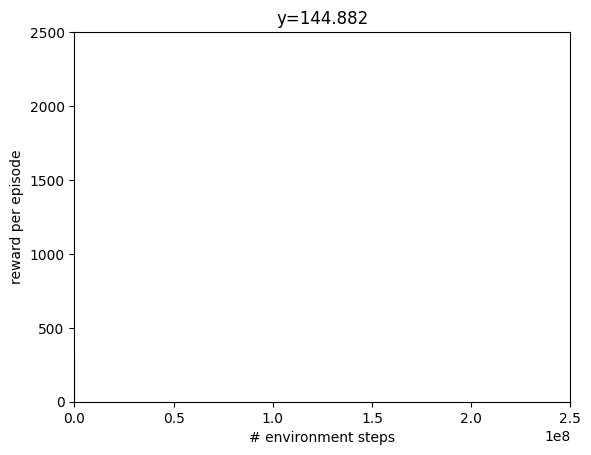

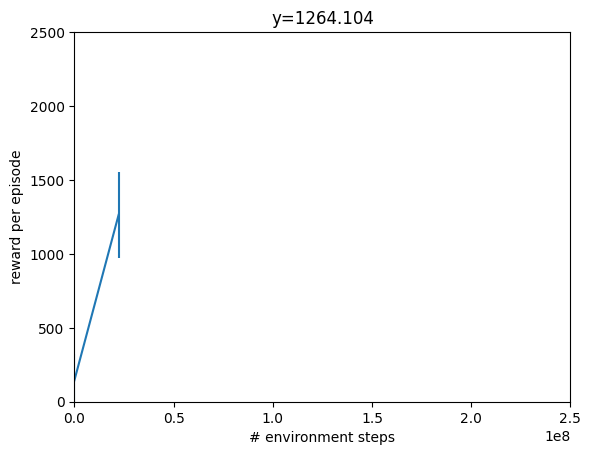

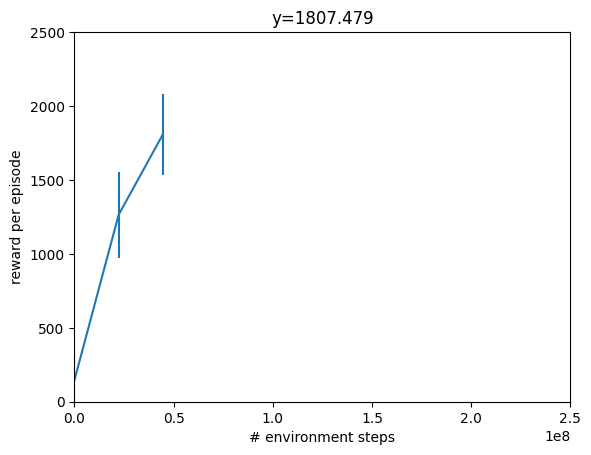

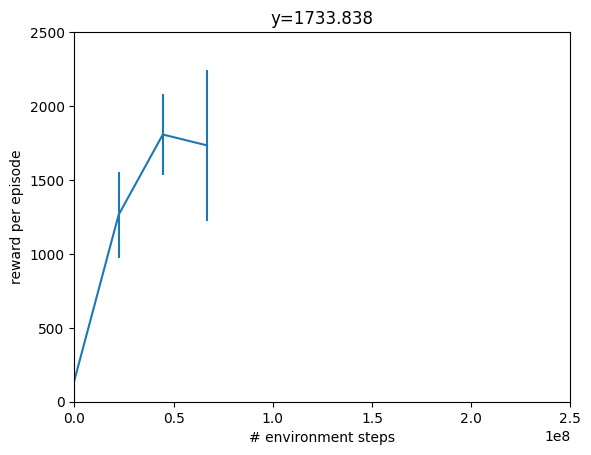

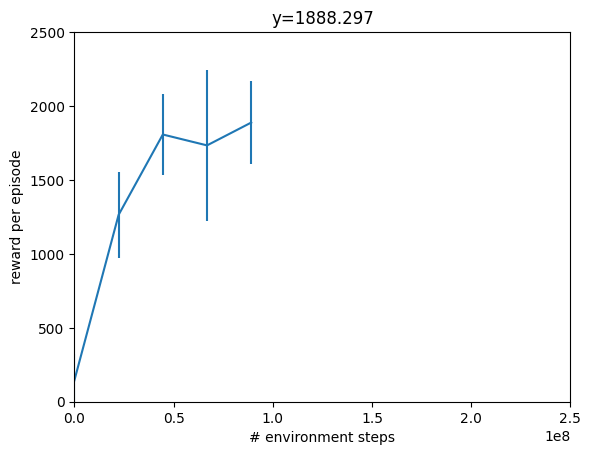

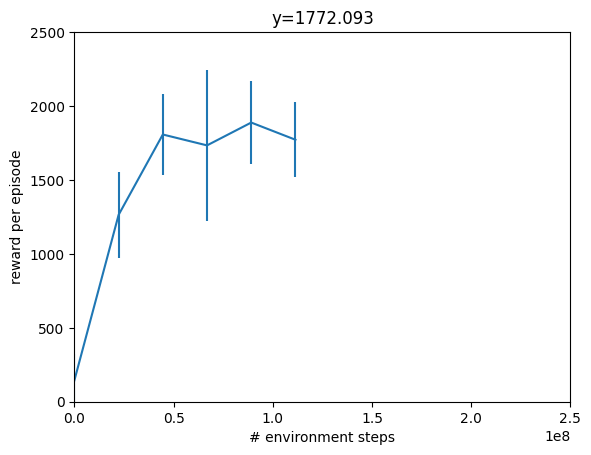

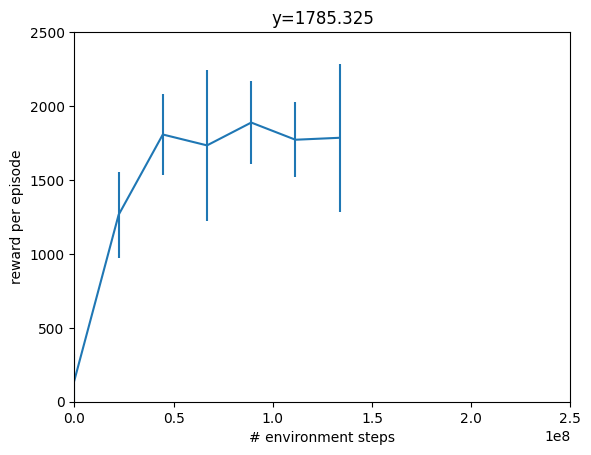

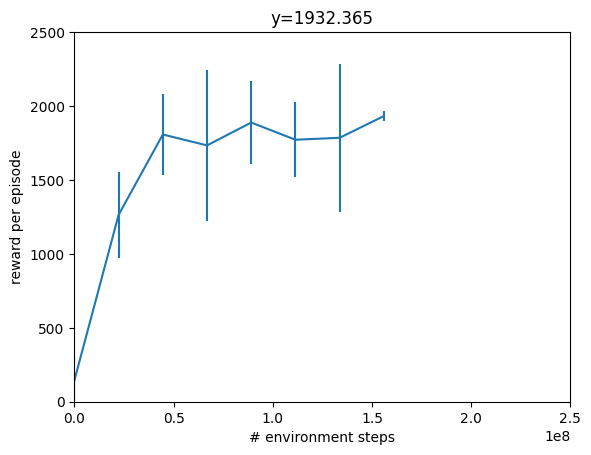

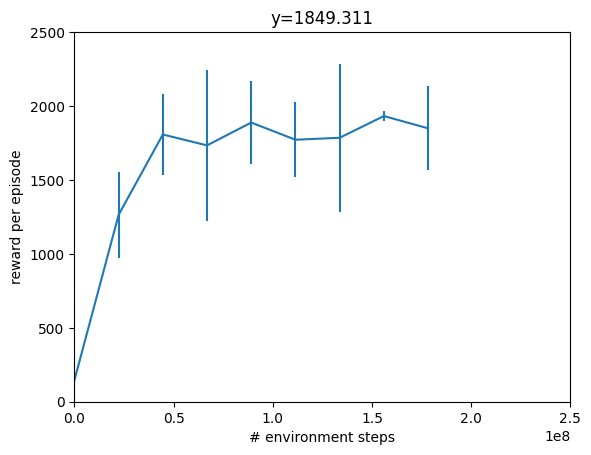

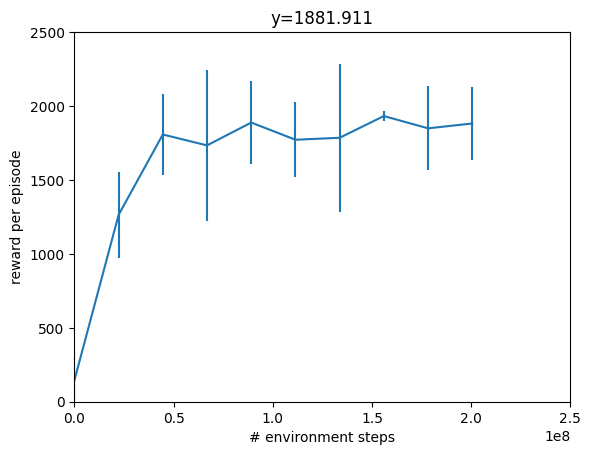

time to jit: 0:00:45.963233
time to train: 0:23:17.528914


In [ ]:
# --- TRAIN INVERTED PENDULUM POLICY ---
# ########### PPO #################
# wandb.init()

make_networks_factory = functools.partial(
    ppo_networks.make_ppo_networks,
        policy_hidden_layer_sizes=(128, 256, 256, 128),
    activation=jax.nn.relu)

# Define the PPO training parameters
train_fn = functools.partial(
    ppo.train,
    num_timesteps=200_000_000,
    num_evals=10,
    reward_scaling=0.1,
    episode_length=1000,
    normalize_observations=True,
    action_repeat=1,
    unroll_length=20,
    num_minibatches=32,
    num_updates_per_batch=4,
    discounting=0.99,
    learning_rate=0.0001,
    entropy_cost=1e-2,
    num_envs=2048,
    batch_size=256,
    network_factory=make_networks_factory,
    seed=1,
    randomization_fn=domain_randomize,
    policy_params_fn=functools.partial(visualize_policy,
                                       eval_env=eval_env,
                                       duration_s=5.0,
                                       output_folder="hi"),
)

x_data = []
y_data = []
ydataerr = []
times = [datetime.now()]

def progress(num_steps, metrics):
  times.append(datetime.now())
  x_data.append(num_steps)
  y_data.append(metrics['eval/episode_reward'])
  ydataerr.append(metrics['eval/episode_reward_std'])

  plt.xlim([0, train_fn.keywords['num_timesteps'] * 1.25])
  plt.ylim([0, 2500])

  plt.xlabel('# environment steps')
  plt.ylabel('reward per episode')
  plt.title(f'y={y_data[-1]:.3f}')

  plt.errorbar(
      x_data, y_data, yerr=ydataerr)
  plt.show()

  # wandb.log(metrics, step=num_steps)

make_inference_fn, params, _= train_fn(environment=env,
                                       progress_fn=progress, )
                                      #  eval_env=eval_env,)
# wandb.finish()

print(f'time to jit: {times[1] - times[0]}')
print(f'time to train: {times[-1] - times[1]}')

# Step 9. Save and export the learned model!

After spending all that time training, we really want to save our model parameters! This will save the file in Colab's internal filesystem. You can access or see the file by clicking on the file icon on the left hand panel.

In [ ]:
# --- SAVE MODEL ---
model_path = '/content/swing_model.params'
model.save_params(model_path, params)

Load the model into a parameters object to test it in our environment.

In [ ]:
# --- LOAD MODEL AND DEFINE INFERENCE FUNCTION ---
params = model.load_params(model_path)
inference_fn = make_inference_fn(params, deterministic=True)
jit_inference_fn = jax.jit(inference_fn)

In [ ]:
# @title Miscellaneous: Policy export helper functions (Run but ignore)

def fold_in_normalization(A, b, mean, std):
    A_prime = A / std[:, np.newaxis]
    b_prime = (b - (A.T @ (mean / std)[:, np.newaxis]).T)[0]
    return A_prime, b_prime

def convert_params(
    params,
    activation: str,
    final_activation: str = "tanh",
):
    mean, std = params[0].mean, params[0].std
    params_dict = params[1]["params"]
    layers = []
    for i, (layer_name, layer_params) in enumerate(params_dict.items()):
        is_first_layer = i == 0
        is_final_layer = i == len(params_dict) - 1
        bias = layer_params["bias"]
        kernel = layer_params["kernel"]
        if is_first_layer:
            kernel, bias = fold_in_normalization(A=kernel, b=bias, mean=mean, std=std)
            input_size = kernel.shape[0]
        if is_final_layer:
            bias, _ = jp.split(bias, 2, axis=-1)
            kernel, _ = jp.split(kernel, 2, axis=-1)

        # Determine the output shape from the bias length
        output_shape = len(bias)

        # Convert kernel to a nested list
        kernel_list = kernel.tolist()

        # Determine the input shape from the kernel shape
        # TODO: Determine whether this is necessary
        # input_shape = len(kernel_list[0])

        # Create layer dictionary
        layer_dict = {
            "type": "dense",
            "activation": activation if not is_final_layer else final_activation,
            "shape": [None, output_shape],
            "weights": [kernel_list, bias.tolist()],
        }

        # Add layer dictionary to layers list
        layers.append(layer_dict)

    # Create policy diction with additional metadata
    final_dict = {
        "in_shape": [None, input_size],
        "layers": layers,
    }

    return final_dict

params_dict = convert_params(params, activation="relu") | {'action_min':env.action_min.item(), 'action_max':env.action_max.item()}

# Note: assuming action_min are action_max are symmetric
assert env.action_min == -env.action_max
params_dict = convert_params(params, activation="relu") | {'action_min':env.action_min.item(), 'action_max':env.action_max.item()}

## Step 10. Download policy params as yaml (to your computer)

As a backup (and to help you send these params to be run on the cartpole), we download them to your local computer.

You can also find the params.yaml file if you click the file icon to the far left.

In [ ]:
import yaml
with open('params.yaml', 'w') as file:
  yaml.dump(params_dict, file, default_flow_style=False)

from google.colab import files
files.download('params.yaml')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Step 11. Visualize our policy!

Now, lets deploy our policy in the mujoco environment and see how it performs!

Hopefully, you should see the policy swing-up and stabilize the cartpole!

In [ ]:
# --- VISUALIZE POLICY ---
# Instantiate the environment
eval_env = InvertedPendulum(xml_string=inverted_pendulum_xml)

# Define the jit reset/step functions
jit_reset = jax.jit(eval_env.reset)
jit_step = jax.jit(eval_env.step)

# Initialize the state
rng = jax.random.PRNGKey(1)
state = jit_reset(rng)

# Initialize the pendulum to any angle
qpos = jp.array([0.0, 0.0])
qvel = jp.array([0.0, 0.0])

# Initialize the pipeline with the positions and velocities
state = state.replace(pipeline_state=eval_env.pipeline_init(qpos, qvel))

rollout = [state.pipeline_state]

# Inspect the state
print("Observation type: ", type(state.obs))
print("Initial observation: ", state.obs)

# Initialize lists to store data
x_positions = []
theta_angles = []
x_velocities = []
theta_velocities = []
actions = []
action_rewards = []
position_rewards = []
angle_rewards = []
angular_velocity_rewards = []
total_rewards = []

# Grab a trajectory

# Simulate for 750 env steps which is 15s
n_steps = 750

for i in range(n_steps):
    act_rng, rng = jax.random.split(rng)
    ctrl, _ = jit_inference_fn(state.obs, act_rng)
    if i >= 10 and i<= 20:
       print(state.obs, end=' ')
       print("total: ", state.reward, " theta: ", state.metrics["reward_theta"])
    state = jit_step(state, ctrl)
    rollout.append(state.pipeline_state)

    # Collect data
    x_positions.append(state.obs[0])
    theta_angles.append(state.obs[1])
    x_velocities.append(state.obs[2])
    theta_velocities.append(state.obs[3])
    actions.append(ctrl)
    action_rewards.append(state.metrics["reward_theta"]*0.0) #state.metrics["reward_action"])
    position_rewards.append(state.metrics["reward_x"])
    angle_rewards.append(state.metrics["reward_theta"])
    angular_velocity_rewards.append(state.metrics["reward_theta_dot"])
    total_rewards.append(state.reward)

    # if state.done:
    #     break

media.show_video(env.render(rollout, width=480, height=480), fps=1.0/env.dt)

Observation type:  <class 'jaxlib._jax.ArrayImpl'>
Initial observation:  [ 0.101 -0.605  0.116 -2.164]
[0.161 0.362 1.063 1.947] total:  0.9971729  theta:  0.00044161698
[0.181 0.397 0.99  1.593] total:  0.99762326  theta:  0.00053487153
[0.2   0.424 0.917 1.229] total:  0.9980733  theta:  0.00062150176
[0.218 0.445 0.872 0.917] total:  0.99843055  theta:  0.0006957208
[0.235 0.46  0.843 0.634] total:  0.9987233  theta:  0.0007539708
[0.252 0.47  0.818 0.357] total:  0.998983  theta:  0.00079272577
[0.268 0.473 0.794 0.078] total:  0.99921954  theta:  0.0008089223
[ 0.283  0.472  0.771 -0.195] total:  0.99903226  theta:  0.0008015135
[ 0.299  0.464  0.745 -0.471] total:  0.9986633  theta:  0.0007711532
[ 0.313  0.452  0.717 -0.749] total:  0.9982733  theta:  0.00072007655
[ 0.327  0.433  0.689 -1.021] total:  0.9978722  theta:  0.00065249053


## Step 12. Plot system variables.

Let's plot the system variables of our RL policy to check performance!

Pay special attentin to the position, velocity, actions, and reward vs. time.

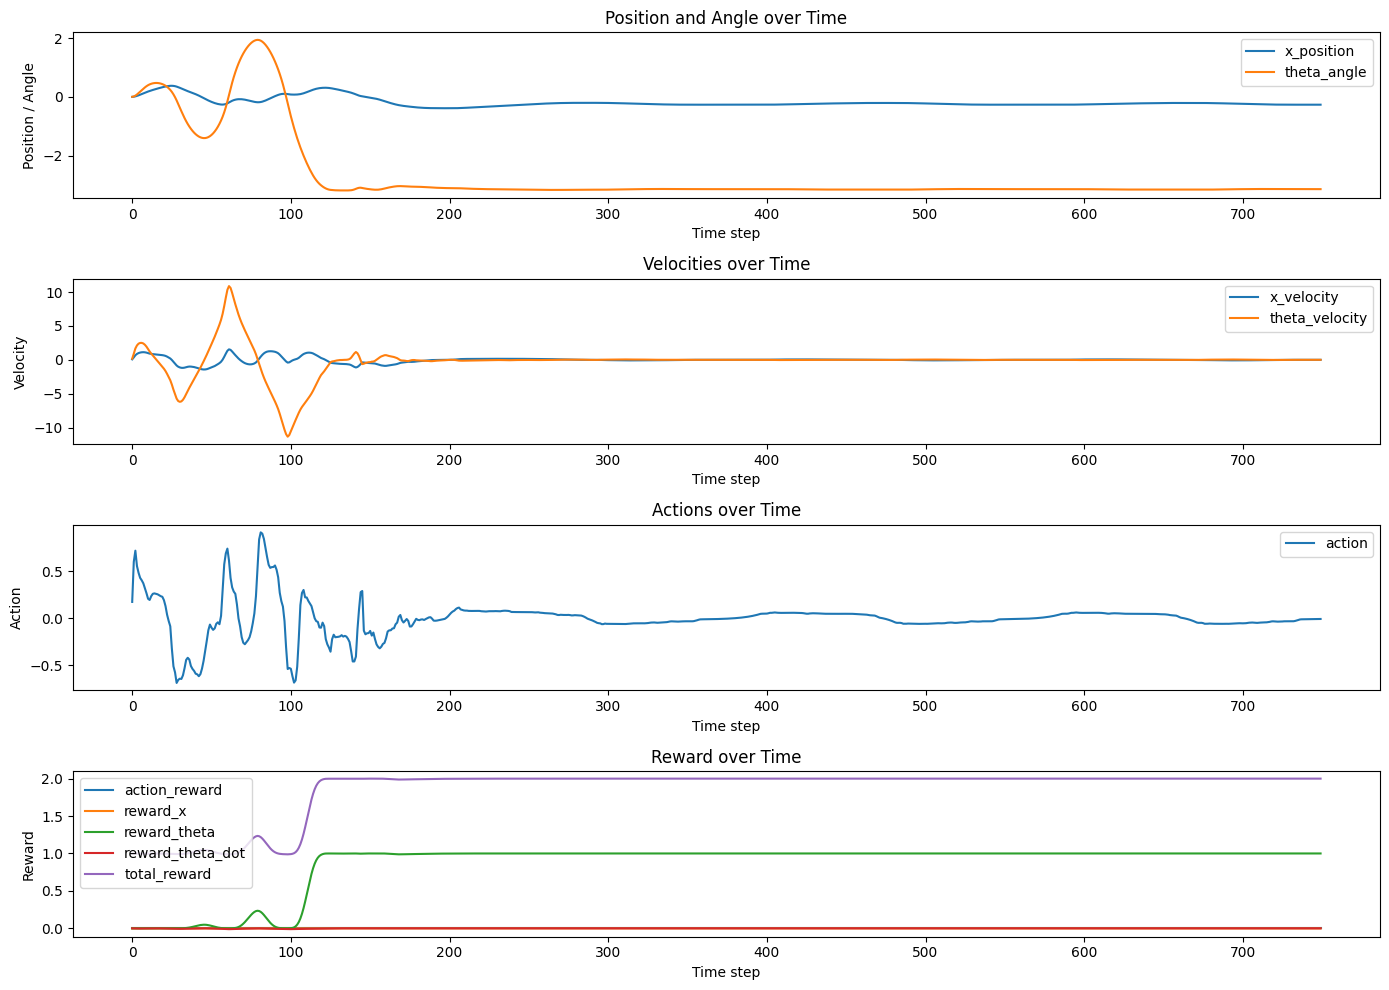

In [ ]:
# --- PLOT STATE VARIABLES AND REWARD ---
# Plot the state variables, actions, and rewards over time
time_steps = range(len(x_positions))

plt.figure(figsize=(14, 10))

plt.subplot(4, 1, 1)
plt.plot(time_steps, x_positions, label='x_position')
plt.plot(time_steps, theta_angles, label='theta_angle')
plt.xlabel('Time step')
plt.ylabel('Position / Angle')
plt.legend()
plt.title('Position and Angle over Time')

plt.subplot(4, 1, 2)
plt.plot(time_steps, x_velocities, label='x_velocity')
plt.plot(time_steps, theta_velocities, label='theta_velocity')
plt.xlabel('Time step')
plt.ylabel('Velocity')
plt.legend()
plt.title('Velocities over Time')

plt.subplot(4, 1, 3)
plt.plot(time_steps, actions, label='action')
plt.xlabel('Time step')
plt.ylabel('Action')
plt.legend()
plt.title('Actions over Time')

plt.subplot(4, 1, 4)
plt.plot(time_steps, action_rewards, label='action_reward')
plt.plot(time_steps, position_rewards, label='reward_x')
plt.plot(time_steps, angle_rewards, label='reward_theta')
plt.plot(time_steps, angular_velocity_rewards, label='reward_theta_dot')
plt.plot(time_steps, total_rewards, label='total_reward')
plt.xlabel('Time step')
plt.ylabel('Reward')
plt.legend()
plt.title('Reward over Time')

plt.tight_layout()
plt.show()

# Great job!! Now try your model on the real system.

If your policy performed well after training, and you would like to try out your policy on the physical cart-pole system, email your `params.yaml` file to:
- `james.wang@afwerxpartner.com`,
- and cc: `nsimon@princeton.edu`.